In [1]:
from contextlib import contextmanager
import cv2 as cv
from IPython import display
import math
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [2]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks
    
@contextmanager
def VideoCapture(input_video):

    # findFileOrKeep allows more searching paths
    capture = cv.VideoCapture(cv.samples.findFileOrKeep(input_video))
    if not capture.isOpened():
        print('Unable to open: ' + input_video)
        exit(0)

    try:
        yield capture
    finally:
        # Release the video capture object at the end
        capture.release()    

In [3]:
def drawAxis(img, p_, q_, colour, scale, width=20):
    p = list(p_)
    q = list(q_)
    
    angle = math.atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = math.sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * math.cos(angle)
    q[1] = p[1] - scale * hypotenuse * math.sin(angle)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, width, cv.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * math.cos(angle + math.pi / 4)
    p[1] = q[1] + 9 * math.sin(angle + math.pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, width, cv.LINE_AA)
    p[0] = q[0] + 9 * math.cos(angle - math.pi / 4)
    p[1] = q[1] + 9 * math.sin(angle - math.pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, width, cv.LINE_AA)
    

def crop_pca_orientation(frame, bbox, background_th, min_size=20, plot=True):
    crop = frame[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]]
    pts = np.argwhere(crop < background_th).reshape(-1, 2).astype(np.float32)

    crop_rgb = cv.cvtColor(crop, cv.COLOR_GRAY2RGB)
    for p in pts:
        cv.circle(crop_rgb, p[::-1].astype(int), 3, (255, 0, 255), 1)
    if plot:
        plt.figure(figsize=(6.4 / 2, 4.8 / 2))
        plt.imshow(crop_rgb, cmap='gray', vmin=0, vmax=255)
        plt.show()

    if len(pts) < min_size : return 0

    mean = np.empty((0))
    _, eigenvectors, _ = cv.PCACompute2(pts, mean)

    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    return angle, pts


In [4]:
tracker = PrecomputedMOTTracker('./OUTPUT/all_ants_0-007_yolopca_ocsort04th02ciou_151.txt')
input_video = './DATA/all_ants_0-007.mp4'

<Figure size 640x480 with 0 Axes>

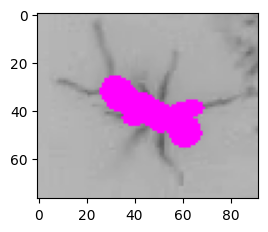

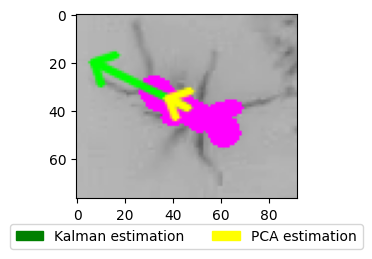

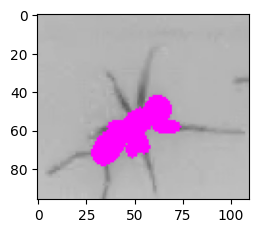

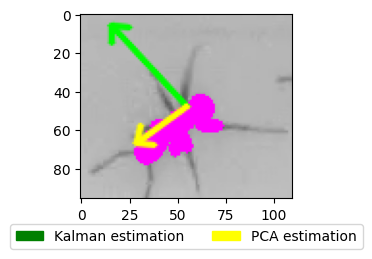

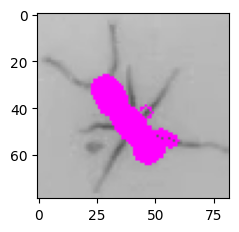

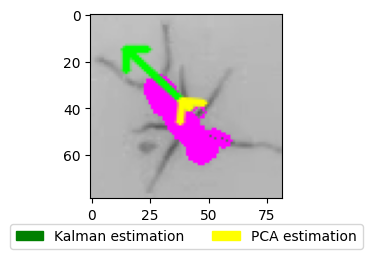

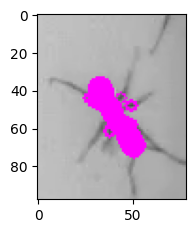

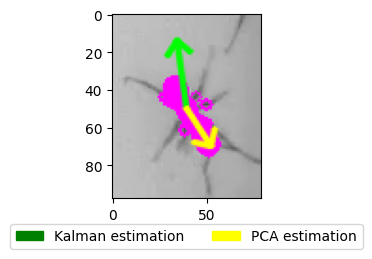

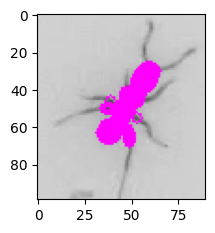

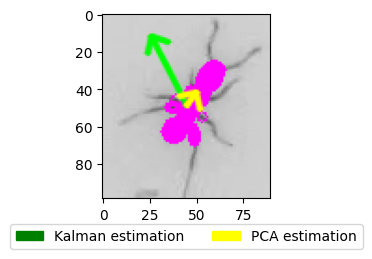

GREEN is KALMAN
YELLOW is PCA


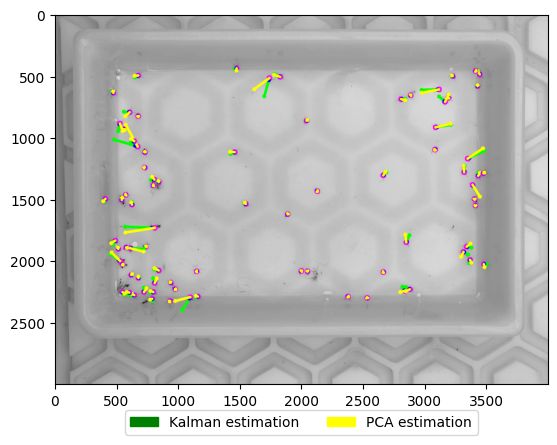

In [5]:
fig = plt.figure()

kalman_patch = mpatches.Patch(color='green', label='Kalman estimation')
pca_patch = mpatches.Patch(color='yellow', label='PCA estimation')

skip = 3
with VideoCapture(input_video) as capture:
    for fr in range(1, tracker.last_frame): # It goes from 1 to T

        tracks = tracker(fr)
        post_tracks = tracker(fr + 1)
        if skip > 0 or len(tracks) == 0:
            skip = max(skip - 1, 0)
            continue

        capture.set(cv.CAP_PROP_POS_FRAMES, fr - 1)
        _, frame = capture.read()
        if frame is None:
            print (f'Frame {fr} is None')
            break

        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        background_th = np.mean(gray_frame) * 0.5

        plotted = 0
        for tck in tracks:
            _, pts = crop_pca_orientation(gray_frame, tck[2:6].astype(int), background_th, 20, plotted < 5)
            cntr = tck[2:4] + tck[4:6] / 2

            cv.circle(frame, cntr.astype(int), 3, (255, 0, 255), 40)

            module = 50
            pca_angle_ori = tck[9]
            if tck[1] in post_tracks[:, 1]:
                post_cntr = post_tracks[post_tracks[:, 1] == tck[1], 2:4].squeeze() + post_tracks[post_tracks[:, 1] == tck[1], 4:6].squeeze() / 2
                module = np.linalg.norm(post_cntr - cntr)
                angle = np.pi / 2 - np.arccos((post_cntr - cntr)[0] / module) * (1. if (post_cntr - cntr)[1] >= 0 else -1.)

                draw_post_cntr = cntr + (post_cntr - cntr) * 10
                drawAxis(frame, cntr, draw_post_cntr, (0, 255, 0), 1)
                cv.circle(frame, post_cntr.astype(int), 3, (0, 0, 255), 25)

                angle_dist = min(np.abs(angle - pca_angle_ori), 2 * np.pi - np.abs(angle - pca_angle_ori))
                pca_angle = pca_angle_ori if (2 * angle_dist) < np.pi else pca_angle_ori - np.pi

                if len(tracks) < 5:
                    print(f'frame number {fr}')
                    angle_print = angle if angle >= 0 else 2 * np.pi + angle
                    pca_angle_print = pca_angle if pca_angle >= 0 else 2 * np.pi + pca_angle
                    pca_angle_ori_print = pca_angle_ori if pca_angle_ori >= 0 else 2 * np.pi + pca_angle_ori
                    print(f'KALMAN: {angle_print * 180 / np.pi:.02f}º\t|\tPCA: {pca_angle_print * 180 / np.pi:.02f}º\t|\tPCA_ori: {pca_angle_ori_print * 180 / np.pi:.02f}º')
                    final_angle_dist = min(np.abs(angle - pca_angle), np.abs( 2 * np.pi - (angle - pca_angle))) * 180 / np.pi
                    print(f'angle_dist: {angle_dist * 180 / np.pi:.02f}º\tfinal angle_dist: {final_angle_dist:.02f}º', end='\n\n')
            
            delta_cntr = module * np.array((np.sin(pca_angle), np.cos(pca_angle))) * 10
            drawAxis(frame, cntr, cntr + delta_cntr, (255, 255, 0), 1)


            # ADDED WITHOUT THINKING TOO MUCH TO GET A PLOT
            if plotted < 5:
                _, bbox, background_th, min_size = gray_frame, tck[2:6].astype(int), background_th, 20

                crop = gray_frame[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]]
                pts = np.argwhere(crop < background_th).reshape(-1, 2).astype(np.float32)

                cntr_crp = cntr
                cntr_crp[0] -= bbox[0]
                cntr_crp[1] -= bbox[1]

                plt.figure(figsize=(6.4 / 2, 4.8 / 2))
                crop_rgb = cv.cvtColor(crop, cv.COLOR_GRAY2RGB)
                for p in pts:
                    cv.circle(crop_rgb, p[::-1].astype(int), 3, (255, 0, 255), 1)
                
                drawAxis(crop_rgb, cntr_crp, draw_post_cntr / 100, (0, 255, 0), 1, 2)
                drawAxis(crop_rgb, cntr_crp, cntr_crp + delta_cntr / 5, (255, 255, 0), 1, 2)

                plt.imshow(crop_rgb, cmap='gray', vmin=0, vmax=255)
                plt.legend(handles=[kalman_patch, pca_patch], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
                plt.show()
                plotted += 1
            # END OF ADDED WITHOUT THINKING TOO MUCH TO GET A PLOT
        
        if len(tracks) == 1:
            crop = tracks[0, 2:6].astype(int)
            zoom = 0.75
            crop[:2] = (crop[:2] * zoom).astype(int)
            crop[2:] = (crop[2:] + ((frame.shape[:2][::-1] - crop[2:]) * (1 - zoom))).astype(int)
            frame = frame[crop[1] : crop[1] + crop[3], crop[0] : crop[0] + crop[2], :]

        print(f'GREEN is KALMAN\nYELLOW is PCA')
        plt.imshow(frame)
        plt.legend(handles=[kalman_patch, pca_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
        plt.show()
        
        try:
            skip = int(input() or 0)
        except:
            skip = -1

        if skip < 0:
            break
        display.clear_output(wait=True)

In [6]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def tracker_to_tracker_pca(tracker):
    tck_id_sort = np.argsort(tracker.seq_dets[:, 1], kind="stable")

    first_mask = tracker.seq_dets[tck_id_sort[:-1], 1] != tracker.seq_dets[tck_id_sort[1:], 1] # sorted, from 0 to t-1
    first_mask = np.concatenate(([True], first_mask), axis=0)
    first_vals = tracker.seq_dets[tck_id_sort[first_mask], 2:4].copy()

    centers = np.array(center(tracker.seq_dets[:, 2:6])).T # unsorted
    desplazamiento = centers[tck_id_sort[1:], :] - centers[tck_id_sort[:-1], :] # sorted
    modulos = np.linalg.norm(desplazamiento, axis=1).reshape(-1, 1) # sorted

    pos_neg = np.ones(desplazamiento[:, 1].shape).reshape(-1, 1)
    pos_neg[desplazamiento[:, 1] < 0] = -1 # sorted
    angulos_kalman = np.pi / 2 - np.arccos(desplazamiento[:, 0].reshape(-1, 1) / modulos) * pos_neg # sorted

    angulos_pca = tracker.seq_dets[tck_id_sort, 9][:-1].reshape(-1, 1) # sorted
    angle_dist = np.min((np.abs(angulos_kalman - angulos_pca), 2 * np.pi - np.abs(angulos_kalman - angulos_pca)), axis=0) #sorted
    angulos_pca[(2 * angle_dist) >= np.pi] = angulos_pca[(2 * angle_dist) >= np.pi] - np.pi

    origins = tracker.seq_dets[tck_id_sort, 2:4][:-1, :].reshape(-1, 2)

    tracker.seq_dets[tck_id_sort[1:], 2:4] = origins + modulos * np.hstack([np.sin(angulos_pca), np.cos(angulos_pca)]).reshape(-1, 2)
    tracker.seq_dets[tck_id_sort[first_mask], 2:4] = first_vals

    tracker.seq_dets = np.hstack((tracker.seq_dets, np.concatenate((angulos_pca, tracker.seq_dets[-1, 9].reshape(-1, 1)), axis=0).reshape(-1, 1)))

In [7]:
gt_tracker = PrecomputedMOTTracker('./DATA/all_ants_0-007_gt_tcks.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/all_ants_0-007_yolopca_ocsort04th02ciou_151.txt')

pca_tracker = PrecomputedMOTTracker('./OUTPUT/all_ants_0-007_yolopca_ocsort04th02ciou_151.txt')
tracker_to_tracker_pca(pca_tracker)

/tmp/ipykernel_2695/615826789.py:20: RuntimeWarning: invalid value encountered in divide
  angulos_kalman = np.pi / 2 - np.arccos(desplazamiento[:, 0].reshape(-1, 1) / modulos) * pos_neg # sorted


GREEN is KALMAN	|	YELLOW is PCA	|	BLUE is GT	|	RED is MOVE ORIGIN


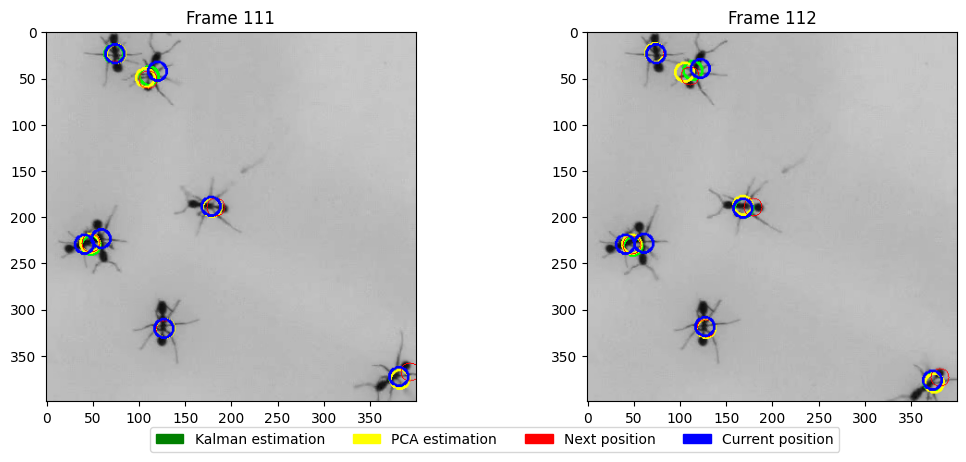

In [10]:

radius = 10 # 3

kalman_patch = mpatches.Patch(color='green', label='Kalman estimation')
pca_patch = mpatches.Patch(color='yellow', label='PCA estimation')
gt1_patch = mpatches.Patch(color='blue', label='Current position')
gt2_patch = mpatches.Patch(color='red', label='Next position')

prev_frame = None
prev_fr = -1
skip = 0
with VideoCapture(input_video) as capture:
    for fr in range(1, tracker.last_frame + 1):

        ori_tracks = tracker(fr - 1)
        tracks = tracker(fr)
        pca_tracks = pca_tracker(fr)
        gt_tracks = gt_tracker(fr)
        if skip > 0 or len(tracks) == 0:
            skip = max(skip - 1, 0)
            continue

        capture.set(cv.CAP_PROP_POS_FRAMES, fr - 1)
        _, frame = capture.read()
        if frame is None:
            print (f'Frame {fr} is None')
            break
        
        if prev_frame is None:
            prev_frame = np.zeros(frame.shape)

        for tck, pca_tck in zip(tracks, pca_tracks):

            #print(f'{pca_tck[10] * 180 / np.pi}º')

            cntr = tck[2:4] + tck[4:6] / 2
            pca_cntr = pca_tck[2:4] + pca_tck[4:6] / 2

            cv.circle(frame, cntr.astype(int), radius, (0, 255, 0), 2)
            cv.circle(frame, pca_cntr.astype(int), radius, (255, 255, 0), 2)

            if tck[1] in ori_tracks[:, 1]:
                ori_cntr = ori_tracks[ori_tracks[:, 1] == tck[1], 2:4] + ori_tracks[ori_tracks[:, 1] == tck[1], 4:6] / 2
                cv.circle(frame, ori_cntr.flatten().astype(int), radius, (255, 0, 0), 1)

        for gt_tck in gt_tracks:
            gt_cntr = gt_tck[2:4] + gt_tck[4:6] / 2
            cv.circle(frame, gt_cntr.astype(int), radius, (0, 0, 255), 2)

        if len(tracks) == 1:
            crop = tracks[0, 2:6].astype(int)
            zoom = 0.9
            crop[:2] = (crop[:2] * zoom).astype(int)
            crop[2:] = (crop[2:] + ((frame.shape[:2][::-1] - crop[2:]) * (1 - zoom))).astype(int)
            frame = frame[crop[1] : crop[1] + crop[3], crop[0] : crop[0] + crop[2], :]
        else:
            frame = frame[800 : 1200, 600 : 1000, :]

        #print (f'FRAME: {fr}')
        print(f'GREEN is KALMAN\t|\tYELLOW is PCA\t|\tBLUE is GT\t|\tRED is MOVE ORIGIN')
        plt.figure(figsize=(6.4 * 2, 4.8))
        ax2 = plt.subplot(1, 2, 1)
        plt.imshow(prev_frame)
        ax2.set_title(f"Frame {prev_fr}")
        ax1 = plt.subplot(1, 2, 2)
        plt.imshow(frame)
        ax1.set_title(f"Frame {fr}")
        plt.legend(handles=[kalman_patch, pca_patch, gt2_patch, gt1_patch], loc='upper center', bbox_to_anchor=(-0.25, -0.05), ncol=4)
        plt.show()
        
        prev_frame = frame
        prev_fr = fr

        try:
            skip = int(input() or 0)
        except:
            skip = -1

        if skip < 0:
            break
        display.clear_output(wait=True)

print('')